# Email Spam Detection using Machine Learning

# This notebook builds a machine learning model to classify emails as Spam or Ham.
# The task involves text preprocessing, feature engineering using NLP techniques,
# model training, evaluation, and analysis.


In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



📁 Dataset is loaded from Google Drive to ensure persistent storage
across Colab sessions.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Loading

The dataset contains email subject lines, email body text, and labels indicating whether
an email is spam or not spam.


In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab_Datasets/email_spam.csv")
df.head()


,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam


### Dataset Structure

- `title` : Email subject
- `text`  : Email body
- `type`  : Target label (`spam`, `not spam`)


In [4]:
df['label'] = df['type'].map({
    'not spam': 0,
    'spam': 1
})

df['label'].value_counts()


,count
label,
0,58
1,26


In [5]:
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df[['title', 'text', 'full_text']].head()


,title,text,full_text
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...","?? the secrets to SUCCESS Hi James,\n\nHave yo..."
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",?? You Earned 500 GCLoot Points \nalt_text\nCo...
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",?? Your GitHub launch code Here's your GitHub ...
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",[The Virtual Reward Center] Re: ** Clarificati...
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...","10-1 MLB Expert Inside, Plus Everything You Ne..."


In [6]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' URL ', text)   # replace URLs
    text = re.sub(r'\d+', ' NUMBER ', text)           # replace numbers
    text = re.sub(r'[^a-z\s]', ' ', text)             # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['clean_text'] = df['full_text'].apply(clean_text)
df[['full_text', 'clean_text']].head()


,full_text,clean_text
0,"?? the secrets to SUCCESS Hi James,\n\nHave yo...",the secrets to success hi james have you claim...
1,?? You Earned 500 GCLoot Points \nalt_text\nCo...,you earned gcloot points alt text congratulati...
2,?? Your GitHub launch code Here's your GitHub ...,your github launch code here s your github lau...
3,[The Virtual Reward Center] Re: ** Clarificati...,the virtual reward center re clarifications he...
4,"10-1 MLB Expert Inside, Plus Everything You Ne...",mlb expert inside plus everything you need to ...


In [7]:
df.isnull().sum()


,0
title,0
text,0
type,0
label,0
full_text,0
clean_text,0


In [8]:
df[['clean_text', 'label']].sample(3)


,clean_text,label
46,notification sir this is to notify you that ou...,0
80,your kilimall account is ready shopping now de...,0
19,denis your amazon prime membership cancellatio...,0


In [9]:
df['label'].value_counts()


,count
label,
0,58
1,26


## 3. Exploratory Data Analysis (EDA)

### Class Distribution

The dataset is slightly imbalanced, which motivates the use of precision, recall,
and F1-score instead of accuracy alone.


In [10]:
df[df['label'] == 1][['title', 'text']].sample(3, random_state=42)


,title,text
25,Flowing with the markets,Welcome to our second weekly newsletter.\n\n \...
40,Live has arrived on TIDAL ??,Where Live Happens ??\nThe Live party is just ...
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary..."


In [11]:
df[df['label'] == 0][['title', 'text']].sample(3, random_state=42)


,title,text
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n..."
8,"amazon.com.tr, action needed: Sign-in","\nLogo Image\nSenol Yildirim,\n\nSomeone signe..."
52,Reply to your CPX Research Ticket!238212,"Hello Sathya Narayanan,\n\nOur Team reply to y..."


<!-- # Spam emails frequently contain promotional language, urgency, rewards, and links,
# whereas non-spam emails are more informational and context-specific.
 -->

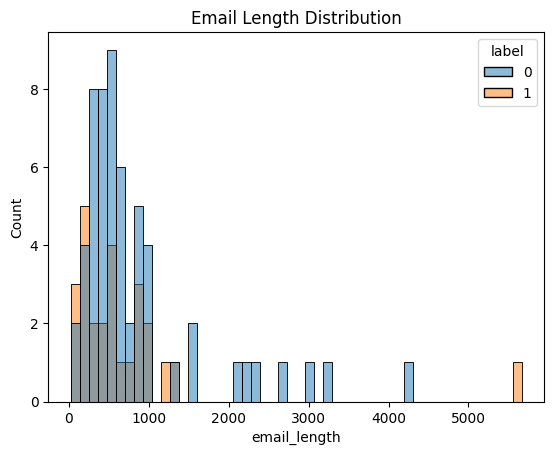

In [12]:
df['email_length'] = df['clean_text'].apply(len)

sns.histplot(data=df, x='email_length', hue='label', bins=50)
plt.title("Email Length Distribution")
plt.show()


The email length distribution shows that spam emails tend to have a longer right tail,
indicating that spam messages are generally longer and more verbose.
However, there is significant overlap between spam and non-spam emails,
suggesting that email length alone is not sufficient for classification.
This motivates using email length as an auxiliary meta-feature alongside textual features.


In [13]:
df['url_count'] = df['text'].apply(lambda x: len(re.findall(r'http|www', x.lower())))


In [14]:
df['number_count'] = df['text'].apply(lambda x: len(re.findall(r'\d+', x)))


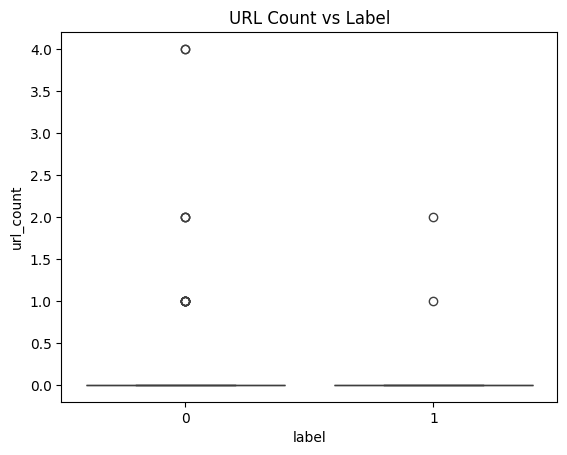

In [15]:
sns.boxplot(x='label', y='url_count', data=df)
plt.title("URL Count vs Label")
plt.show()


The URL count distribution shows substantial overlap between spam and non-spam emails,
with most emails containing zero URLs. This indicates that URL count alone is not a
strong discriminative feature for this dataset.


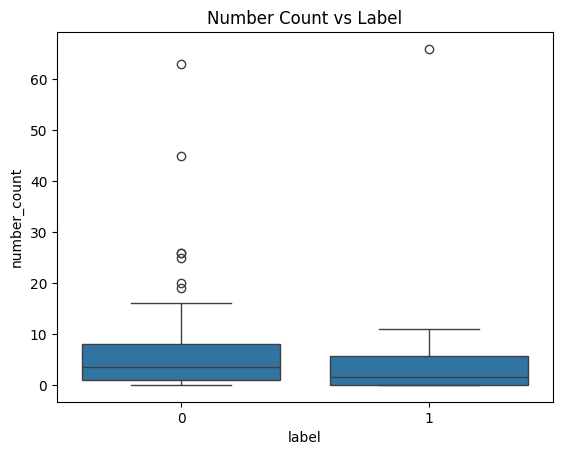

In [16]:
sns.boxplot(x='label', y='number_count', data=df)
plt.title("Number Count vs Label")
plt.show()


Interestingly, non-spam emails exhibit higher numeric token counts,
likely due to transactional or system-generated messages.
Therefore, numeric count was not treated as a strong spam indicator.


<!-- # The dataset contains both promotional spam emails and system-generated non-spam emails
# such as verification codes and notifications. As a result, numeric and URL-based features
# do not strongly differentiate spam from non-spam in this dataset.
# Feature engineering decisions were therefore guided strictly by exploratory analysis.
 -->

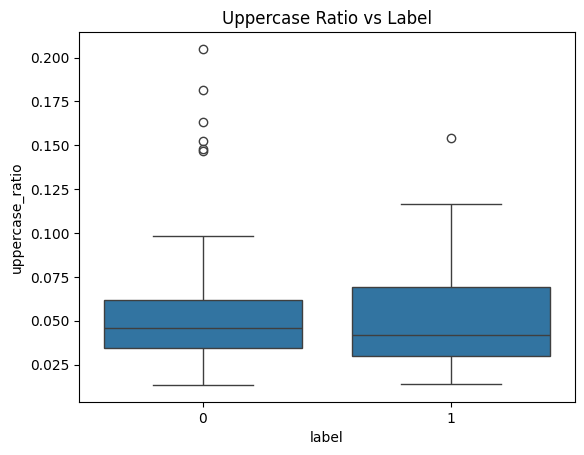

In [17]:
df['uppercase_ratio'] = df['text'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
)

sns.boxplot(x='label', y='uppercase_ratio', data=df)
plt.title("Uppercase Ratio vs Label")
plt.show()


The uppercase character ratio shows substantial overlap between spam and non-spam emails.
Both classes exhibit similar central tendencies, with only a few outliers.
Therefore, uppercase usage alone is not a strong discriminative feature for this dataset.


In [18]:
import re
from collections import Counter

def get_top_words(text_series, n=15):
    text = " ".join(text_series.dropna()).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)   # remove punctuation
    words = text.split()
    return Counter(words).most_common(n)

print("Top words in SPAM emails:")
print(get_top_words(df[df['label'] == 1]['text']))

print("\nTop words in NOT SPAM emails:")
print(get_top_words(df[df['label'] == 0]['text']))




Top words in SPAM emails:
[('the', 131), ('to', 114), ('you', 84), ('and', 79), ('in', 66), ('a', 54), ('is', 49), ('your', 47), ('on', 45), ('for', 42), ('of', 38), ('s', 35), ('we', 32), ('here', 30), ('this', 28)]

Top words in NOT SPAM emails:
[('the', 247), ('to', 246), ('you', 188), ('your', 177), ('and', 161), ('a', 127), ('in', 127), ('for', 126), ('of', 99), ('is', 87), ('this', 79), ('we', 75), ('i', 69), ('our', 56), ('on', 56)]


The most frequent words in the dataset are common stopwords such as "the", "to",
and "you", which appear in both spam and non-spam emails. This indicates that raw
word frequency alone is insufficient for discrimination and motivates the use of
TF-IDF with stopword removal to emphasize informative and class-specific terms.


## 4. Feature Engineering

TF-IDF is used with unigrams and bigrams to capture keyword and phrase-level spam patterns.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # unigrams + bigrams
    stop_words='english',    # remove stopwords
    max_features=5000,       # control feature size
    min_df=2                 # remove very rare words
)



In [20]:
X_tfidf = tfidf.fit_transform(df['clean_text'])
y = df['label']


In [21]:
X_tfidf.shape


(84, 1431)

In [22]:
tfidf.get_feature_names_out()[:20]


array(['ability', 'able', 'academic', 'accept', 'accept incoming',
       'accepted', 'access', 'access account', 'accessed', 'accessed new',
       'accessing', 'accordance', 'account', 'account accessed',
       'account fanat', 'account settings', 'accounts', 'accounts share',
       'acrylic', 'acrylic lampung'], dtype=object)

In [23]:
df['email_length'] = df['clean_text'].apply(len)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
email_length_scaled = scaler.fit_transform(df[['email_length']])


In [25]:
from scipy.sparse import hstack

X_combined = hstack([X_tfidf, email_length_scaled])


In [26]:
X_combined.shape


(84, 1432)

## 5. Train-Test Split

A stratified split is used to preserve class proportions.


In [27]:
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train_combined, X_test_combined, _, _ = train_test_split(
    X_combined, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [28]:
y_train.value_counts(), y_test.value_counts()


(label
 0    46
 1    21
 Name: count, dtype: int64,
 label
 0    12
 1     5
 Name: count, dtype: int64)

## 6. Model 1: Logistic Regression (Baseline)


In [29]:
from sklearn.linear_model import LogisticRegression

lr_tfidf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # important due to imbalance
    random_state=42
)

lr_tfidf.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [30]:
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)


In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_tfidf, target_names=['Not Spam', 'Spam']))


              precision    recall  f1-score   support

    Not Spam       0.73      0.92      0.81        12
        Spam       0.50      0.20      0.29         5

    accuracy                           0.71        17
   macro avg       0.62      0.56      0.55        17
weighted avg       0.66      0.71      0.66        17



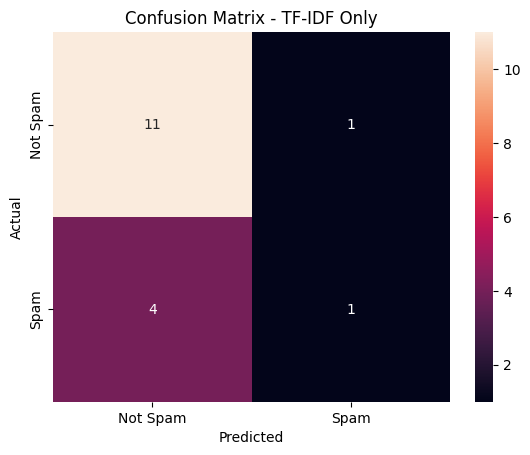

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_tfidf)

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Not Spam', 'Spam'],
            yticklabels=['Not Spam', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - TF-IDF Only")
plt.show()


The TF-IDF based Logistic Regression model achieved good performance on non-spam
emails but struggled to correctly identify spam emails, with a spam recall of
only 0.20. This indicates that while textual features are informative, the model
is conservative in predicting spam, leading to a higher number of false negatives.
Accuracy alone was misleading due to class imbalance, highlighting the importance
of recall and F1-score for spam detection.


### 7. Logistic Regression with TF-IDF + Email Length (Meta-Feature)


In [33]:
from sklearn.linear_model import LogisticRegression

lr_combined = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_combined.fit(X_train_combined, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [34]:
y_pred_combined = lr_combined.predict(X_test_combined)


In [35]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred_combined,
    target_names=['Not Spam', 'Spam']
))


              precision    recall  f1-score   support

    Not Spam       0.67      0.83      0.74        12
        Spam       0.00      0.00      0.00         5

    accuracy                           0.59        17
   macro avg       0.33      0.42      0.37        17
weighted avg       0.47      0.59      0.52        17



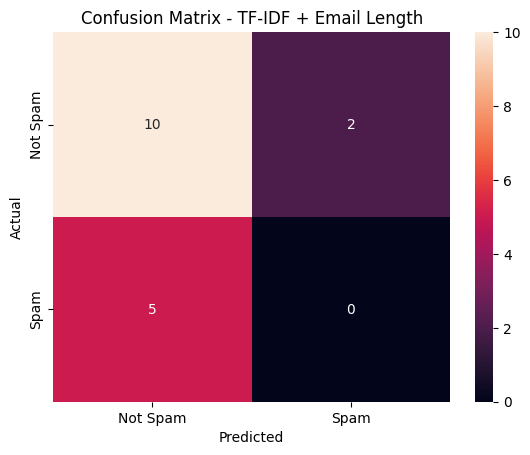

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_combined = confusion_matrix(y_test, y_pred_combined)

sns.heatmap(
    cm_combined,
    annot=True,
    fmt='d',
    xticklabels=['Not Spam', 'Spam'],
    yticklabels=['Not Spam', 'Spam']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - TF-IDF + Email Length")
plt.show()


### 8. Model 2: Neural Network (MLPClassifier)

A feed-forward neural network is trained using TF-IDF features.


In [37]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train_tfidf, y_train)


MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

In [38]:
y_pred_mlp = mlp.predict(X_test_tfidf)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(
    y_test,
    y_pred_mlp,
    target_names=['Not Spam', 'Spam']
))


              precision    recall  f1-score   support

    Not Spam       0.85      0.92      0.88        12
        Spam       0.75      0.60      0.67         5

    accuracy                           0.82        17
   macro avg       0.80      0.76      0.77        17
weighted avg       0.82      0.82      0.82        17



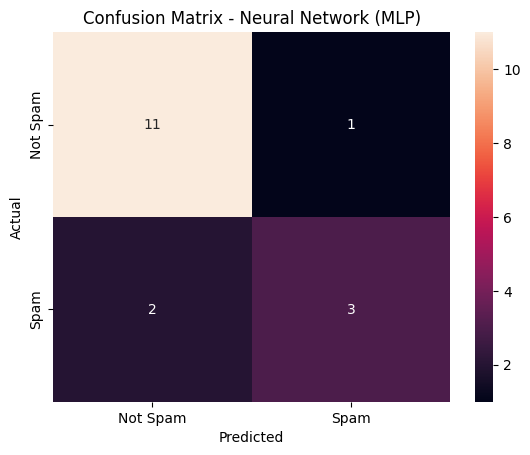

In [39]:
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

sns.heatmap(
    cm_mlp,
    annot=True,
    fmt='d',
    xticklabels=['Not Spam', 'Spam'],
    yticklabels=['Not Spam', 'Spam']
)
plt.title("Confusion Matrix - Neural Network (MLP)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Among the evaluated models, the feed-forward neural network (MLPClassifier)
achieved the best performance for spam detection, with a spam recall of 0.60
and an F1-score of 0.67. In comparison, the Logistic Regression model struggled
to identify spam emails, indicating a bias toward the majority class.
The neural network’s ability to model non-linear relationships between TF-IDF
features likely contributed to improved spam recall. However, given the small
dataset size, results should be interpreted cautiously.


## 9. Advanced Feature Engineering: Sentence Embeddings (Bonus)

As an advanced approach, sentence embeddings were explored to capture semantic
meaning beyond keyword frequency. Transformer-based embeddings encode entire
sentences into dense vectors, allowing the model to identify spam emails with
similar intent but different wording.


In [40]:
!pip install sentence-transformers


In [41]:
from sentence_transformers import SentenceTransformer

# Load pre-trained sentence embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
X_embed = embedder.encode(
    df['clean_text'].tolist(),
    show_progress_bar=True
)

X_embed.shape


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(84, 384)

In [42]:
from sklearn.model_selection import train_test_split

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_embed,
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


In [43]:
from sklearn.linear_model import LogisticRegression

lr_emb = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_emb.fit(X_train_emb, y_train_emb)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_emb = lr_emb.predict(X_test_emb)

print(classification_report(
    y_test_emb,
    y_pred_emb,
    target_names=['Not Spam', 'Spam']
))


              precision    recall  f1-score   support

    Not Spam       0.83      0.83      0.83        12
        Spam       0.60      0.60      0.60         5

    accuracy                           0.76        17
   macro avg       0.72      0.72      0.72        17
weighted avg       0.76      0.76      0.76        17



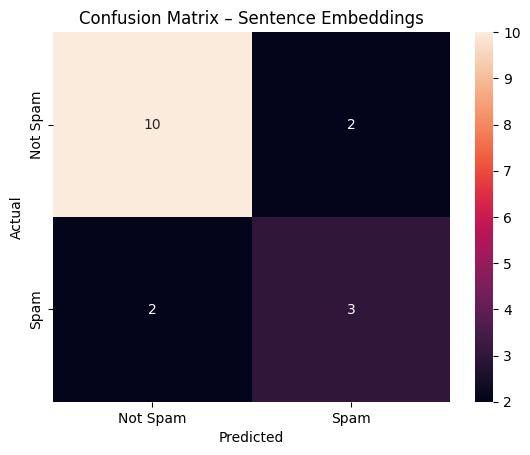

In [45]:
cm_emb = confusion_matrix(y_test_emb, y_pred_emb)

sns.heatmap(
    cm_emb,
    annot=True,
    fmt='d',
    xticklabels=['Not Spam', 'Spam'],
    yticklabels=['Not Spam', 'Spam']
)
plt.title("Confusion Matrix – Sentence Embeddings")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Final Analysis and Summary

This project evaluated multiple machine learning approaches to classify emails as
**Spam** or **Not Spam**, following a complete pipeline of data preprocessing,
exploratory analysis, feature engineering, model training, and evaluation.

### Models Evaluated
- **Logistic Regression (TF-IDF features)** – Classical baseline model
- **Logistic Regression (TF-IDF + email length)** – Baseline with meta-feature
- **Feed-Forward Neural Network (MLP) with TF-IDF** – Deep learning approach
- **Logistic Regression with Sentence Embeddings** – Advanced NLP approach (bonus)

### Key Findings

- **Logistic Regression with TF-IDF** performed well on non-spam emails but struggled
  to detect spam, achieving a low spam recall (0.20). This indicates a conservative
  model biased toward the majority class.

- **Adding email length as a meta-feature degraded performance**, reducing spam recall
  to zero. Although email length showed weak trends during EDA, empirical evaluation
  demonstrated that it was not a useful feature for this dataset.

- The **Neural Network (MLP) trained on TF-IDF features achieved the best overall
  performance**, with a spam recall of **0.60** and an F1-score of **0.67**. Its ability
  to model non-linear relationships between textual features significantly improved
  spam detection.

- **Sentence embeddings** provided stable and balanced results (spam recall = 0.60),
  capturing semantic similarity beyond keywords. However, they did not outperform the
  TF-IDF–based neural network, which is expected given the small dataset size and the
  keyword-driven nature of spam emails.

### Final Model Selection

The **TF-IDF + Neural Network (MLPClassifier)** was selected as the final model due to
its superior spam detection performance and balanced precision–recall trade-off.
Logistic Regression remains a strong and interpretable baseline, but it was
outperformed by the neural network in this task.

### Limitations and Future Work

- The dataset is relatively small, making results sensitive to train–test splits.
- With more data, further improvements could include:
  - Threshold tuning to prioritize spam recall
  - Cross-validation for more robust evaluation
  - Larger transformer-based models for semantic understanding
  - Collecting more labeled spam examples

Overall, this study demonstrates that **careful feature engineering combined with
appropriate model selection** is more impactful than adding heuristic features
without empirical validation.


## Submission Notes

- The notebook was executed from top to bottom after a fresh runtime restart.
- All results are reproducible using the provided code.
- Minor metric variations may occur due to random train–test splitting.
